In [69]:
import re
import json
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from itertools import chain

plt.style.use("ggplot")

In [70]:
def build_assessment_json(assessment):
    regex_result = re.findall("'metric': '.*?', 'score': '.*?'", assessment)
    assessment_list = []
    for result in regex_result:
        result = result.replace("\'", "\"")
        assessment_dict = json.loads("{"+result+"}")
        assessment_list.append(assessment_dict)
    return assessment_list

In [71]:
def get_metrics_from_result(assessment_result):
    return [item.get('metric') for item in assessment_result]

def get_scores_from_result(assessment_result):
    return [int(item.get('score')) for item in assessment_result]

def get_scores_from_result_fes(assessment_result):
    return [item.get('score') for item in assessment_result]

In [72]:
def get_principle_from_metric_fairchecker(metric):
    if metric.startswith('F'):
        return 'findable'
    elif metric.startswith('A'):
        return 'accessible'
    elif metric.startswith('I'):
        return 'interoperable'
    else:
        return 'reusable'

In [73]:
def get_principle_from_metric_fuji(metric):
    if metric.startswith("FsF-F"):
        return "findable"
    elif metric.startswith("FsF-A"):
        return "accessible"
    elif metric.startswith("FsF-I"):
        return "interoperable"
    else:
        return "reusable"

In [74]:
def adjust_fes_metric_names(mname):
    if mname == "FA2a":
        return "A2a"
    return mname

# Comparing paper assessments

Merging

In [75]:
fcheck_papers_doi_df = pd.read_csv("assessed_data/orkg_doi_df_FAIRChecker_assessment2023-03-29.csv",  index_col=0)
fcheck_papers_doi_df = fcheck_papers_doi_df[fcheck_papers_doi_df["assessment_status_code"] == 200].reset_index()
fcheck_papers_url_df = pd.read_csv("assessed_data/orkg_url_df_FAIRChecker_assessment2023-03-29.csv", index_col=0)
fcheck_papers_url_df = fcheck_papers_url_df[fcheck_papers_url_df["assessment_status_code"] == 200].reset_index()
fcheck_papers_std_df = pd.read_csv("assessed_data/orkg_stdurl_df_FAIRChecker_assessment2023-03-29.csv", index_col=0)
fcheck_papers_std_df = fcheck_papers_std_df[fcheck_papers_std_df["assessment_status_code"] == 200].reset_index()

fcheck_papers_doi_url_df = pd.merge(fcheck_papers_doi_df, fcheck_papers_url_df, on="paper", suffixes=("_doi", "_url"))
fcheck_papers_all_df = pd.merge(fcheck_papers_doi_url_df, fcheck_papers_std_df, on="paper")
fcheck_papers_all_df = fcheck_papers_all_df[["paper", "FAIR_assessment_doi", "FAIR_assessment_url", "FAIR_assessment"]]
fcheck_papers_all_df.rename(columns={"FAIR_assessment": "FAIR_assessment_std"}, inplace=True)

In [76]:
fuji_papers_doi_df = pd.read_csv("assessed_data/paper_doi_df_F-UJI_assessment.csv", index_col=0)
fuji_papers_url_df = pd.read_csv("assessed_data/paper_url_df_F-UJI_assessment.csv", index_col=0)
fuji_papers_std_df = pd.read_csv("assessed_data/paper_stdurl_df_F-UJI_assessment.csv", index_col=0)

fuji_papers_doi_url_df = pd.merge(fuji_papers_doi_df, fuji_papers_url_df, on=["paper", "metric"], suffixes=("_doi", "_url"))
fuji_papers_all_df = pd.merge(fuji_papers_doi_url_df, fuji_papers_std_df, on=["paper", "metric"])
fuji_papers_all_df = fuji_papers_all_df[["paper", "metric", "score_earned_doi", "score_total_doi", "score_earned_url", "score_total_url", "score_earned", "score_total"]]
fuji_papers_all_df.rename(columns={"score_earned": "score_earned_std", "score_total": "score_total_std"}, inplace=True)
fuji_papers_all_df

fuji_papers_all_df["score_earned_doi"] = fuji_papers_all_df["score_earned_doi"].map(lambda x: str(x))
fuji_papers_all_df["score_total_doi"] = fuji_papers_all_df["score_total_doi"].map(lambda x: str(x))
fuji_papers_all_df["score_earned_url"] = fuji_papers_all_df["score_earned_url"].map(lambda x: str(x))
fuji_papers_all_df["score_total_url"] = fuji_papers_all_df["score_total_url"].map(lambda x: str(x))
fuji_papers_all_df["score_earned_std"] = fuji_papers_all_df["score_earned_std"].map(lambda x: str(x))
fuji_papers_all_df["score_total_std"] = fuji_papers_all_df["score_total_std"].map(lambda x: str(x))
fuji_papers_all_df = fuji_papers_all_df.groupby("paper").agg({
    "metric": ",".join, 
    "score_earned_doi": ",".join, 
    "score_total_doi": ",".join, 
    "score_earned_url": ",".join,
    "score_total_url": ",".join,
    "score_earned_std": ",".join,
    "score_total_std": ",".join
}).reset_index()

In [77]:
fes_papers_doi_df = pd.read_csv("assessed_data/paper_doi_df_fenough_assessment.csv", index_col=0)
fes_papers_doi_df = fes_papers_doi_df[fes_papers_doi_df["assessment_result"].isna() == False]
fes_papers_url_df = pd.read_csv("assessed_data/paper_url_df_fenough_assessment.csv", index_col=0)
fes_papers_url_df = fes_papers_url_df[fes_papers_url_df["assessment_result"].isna() == False]
fes_papers_std_df = pd.read_csv("assessed_data/paper_std_df_fenough_assessment.csv", index_col=0)
fes_papers_std_df = fes_papers_std_df[fes_papers_std_df["assessment_result"].isna() == False]

fes_papers_doi_url_df = pd.merge(fes_papers_doi_df, fes_papers_url_df, on="paper", suffixes=("_doi", "_url"))
fes_papers_all_df = pd.merge(fes_papers_doi_url_df, fes_papers_std_df, on="paper")
fes_papers_all_df = fes_papers_all_df[["paper", "assessment_result_doi", "assessment_result_url", "assessment_result"]]
fes_papers_all_df.rename(columns={"assessment_result": "assessment_result_std"}, inplace=True)
fes_papers_all_df

,paper,assessment_result_doi,assessment_result_url,assessment_result_std
0,http://orkg.org/orkg/resource/R107834,"[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'metadata_identifier_persistence',...","[{'metric': 'unique_identifier', 'score': '1'}..."
1,http://orkg.org/orkg/resource/R107843,"[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'metadata_identifier_persistence',..."
2,http://orkg.org/orkg/resource/R108529,"[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'metadata_identifier_persistence',..."
3,http://orkg.org/orkg/resource/R108713,"[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'metadata_identifier_persistence',...","[{'metric': 'metadata_identifier_persistence',..."
4,http://orkg.org/orkg/resource/R108865,"[{'metric': 'metadata_identifier_persistence',...","[{'metric': 'metadata_identifier_persistence',...","[{'metric': 'metadata_identifier_persistence',..."
...,...,...,...,...
583,http://orkg.org/orkg/resource/R74963,"[{'metric': 'metadata_identifier_persistence',...","[{'metric': 'metadata_identifier_persistence',...","[{'metric': 'metadata_identifier_persistence',..."
584,http://orkg.org/orkg/resource/R74966,"[{'metric': 'metadata_identifier_persistence',...","[{'metric': 'metadata_authorization', 'score':...","[{'metric': 'unique_identifier', 'score': '1'}..."
585,http://orkg.org/orkg/resource/R75702,"[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'metadata_authorization', 'score':..."
586,http://orkg.org/orkg/resource/R78118,"[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'unique_identifier', 'score': '1'}...","[{'metric': 'metadata_identifier_persistence',..."


In [78]:
fcheck_fuji_all_papers_df = pd.merge(fcheck_papers_all_df, fuji_papers_all_df, on="paper", suffixes=("_fcheck", "_fuji"))
all_papers_df = pd.merge(fcheck_fuji_all_papers_df, fes_papers_all_df, on="paper")
all_papers_df
fcheck_papers_all_df = all_papers_df[["paper", "FAIR_assessment_doi", "FAIR_assessment_url", "FAIR_assessment_std"]]
fuji_papers_all_df = all_papers_df[["paper", "metric", "score_earned_doi", "score_total_doi", "score_earned_url", "score_total_url", "score_earned_std", "score_total_std"]]
fes_papers_all_df = all_papers_df[["paper", "assessment_result_doi", "assessment_result_url", "assessment_result_std"]]

FAIR-Checker

In [79]:
def expand_fcheck_paper_df(df):
    df_exp = pd.DataFrame()
    df_exp["paper"] = list(chain.from_iterable([[x]*11 for x in df["paper"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["FAIR_assessment_doi"]]))
    df_exp["score_earned_doi"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["FAIR_assessment_doi"]]))
    df_exp["score_total_doi"] = list(chain.from_iterable([[2]*11 for x in df["paper"]]))
    df_exp["score_earned_url"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["FAIR_assessment_url"]]))
    df_exp["score_total_url"] = list(chain.from_iterable([[2]*11 for x in df["paper"]]))
    df_exp["score_earned_std"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["FAIR_assessment_std"]]))
    df_exp["score_total_std"] = list(chain.from_iterable([[2]*11 for x in df["paper"]]))
    return df_exp

In [80]:
fcheck_papers_all_df_temp = fcheck_papers_all_df
fcheck_papers_all_df_temp["FAIR_assessment_doi"] = fcheck_papers_all_df_temp["FAIR_assessment_doi"].map(lambda x: build_assessment_json(x))
fcheck_papers_all_df_temp["FAIR_assessment_url"] = fcheck_papers_all_df_temp["FAIR_assessment_url"].map(lambda x: build_assessment_json(x))
fcheck_papers_all_df_temp["FAIR_assessment_std"] = fcheck_papers_all_df_temp["FAIR_assessment_std"].map(lambda x: build_assessment_json(x))
fcheck_papers_all_df_temp = expand_fcheck_paper_df(fcheck_papers_all_df_temp)
fcheck_papers_all_df_total = fcheck_papers_all_df_temp.groupby("paper").agg({
    "score_earned_doi": "sum",
    "score_total_doi": "sum",
    "score_earned_url": "sum",
    "score_total_url": "sum",
    "score_earned_std": "sum",
    "score_total_std": "sum"
}).reset_index()
fcheck_papers_all_df_total["score_percent_doi"] = fcheck_papers_all_df_total.apply(lambda x: x["score_earned_doi"]/x["score_total_doi"], axis=1)
fcheck_papers_all_df_total["score_percent_url"] = fcheck_papers_all_df_total.apply(lambda x: x["score_earned_url"]/x["score_total_url"], axis=1)
fcheck_papers_all_df_total["score_percent_std"] = fcheck_papers_all_df_total.apply(lambda x: x["score_earned_std"]/x["score_total_std"], axis=1)
fcheck_papers_all_df_total

,paper,score_earned_doi,score_total_doi,score_earned_url,score_total_url,score_earned_std,score_total_std,score_percent_doi,score_percent_url,score_percent_std
0,http://orkg.org/orkg/resource/R107843,4,22,14,22,4,22,0.181818,0.636364,0.181818
1,http://orkg.org/orkg/resource/R108529,4,22,14,22,4,22,0.181818,0.636364,0.181818
2,http://orkg.org/orkg/resource/R108713,16,22,14,22,16,22,0.727273,0.636364,0.727273
3,http://orkg.org/orkg/resource/R108865,18,22,16,22,18,22,0.818182,0.727273,0.818182
4,http://orkg.org/orkg/resource/R109012,4,22,16,22,4,22,0.181818,0.727273,0.181818
...,...,...,...,...,...,...,...,...,...,...
370,http://orkg.org/orkg/resource/R284394,2,22,14,22,4,22,0.090909,0.636364,0.181818
371,http://orkg.org/orkg/resource/R285303,4,22,14,22,4,22,0.181818,0.636364,0.181818
372,http://orkg.org/orkg/resource/R288372,14,22,14,22,4,22,0.636364,0.636364,0.181818
373,http://orkg.org/orkg/resource/R74963,18,22,2,22,18,22,0.818182,0.090909,0.818182


In [81]:
fcheck_papers_all_df_principle = fcheck_papers_all_df_temp
fcheck_papers_all_df_principle["principle"] = fcheck_papers_all_df_principle["metric"].map(lambda x: get_principle_from_metric_fairchecker(x))
fcheck_papers_all_df_principle = fcheck_papers_all_df_principle.groupby("principle").agg({
    "score_earned_doi": "sum",
    "score_total_doi": "sum",
    "score_earned_url": "sum",
    "score_total_url": "sum",
    "score_earned_std": "sum",
    "score_total_std": "sum"
}).reset_index()
fcheck_papers_all_df_principle["score_percent_doi"] = fcheck_papers_all_df_principle.apply(lambda x: x["score_earned_doi"]/x["score_total_doi"], axis=1)
fcheck_papers_all_df_principle["score_percent_url"] = fcheck_papers_all_df_principle.apply(lambda x: x["score_earned_url"]/x["score_total_url"], axis=1)
fcheck_papers_all_df_principle["score_percent_std"] = fcheck_papers_all_df_principle.apply(lambda x: x["score_earned_std"]/x["score_total_std"], axis=1)
fcheck_papers_all_df_principle["principle"] = pd.Categorical(fcheck_papers_all_df_principle["principle"], ["findable", "accessible", "interoperable", "reusable"])
fcheck_papers_all_df_principle = fcheck_papers_all_df_principle.sort_values("principle")
fcheck_papers_all_df_principle

,principle,score_earned_doi,score_total_doi,score_earned_url,score_total_url,score_earned_std,score_total_std,score_percent_doi,score_percent_url,score_percent_std
1,findable,1010,3000,2214,3000,326,3000,0.336667,0.738000,0.108667
0,accessible,750,750,750,750,750,750,1.000000,1.000000,1.000000
2,interoperable,524,2250,1516,2250,138,2250,0.232889,0.673778,0.061333
3,reusable,226,2250,738,2250,66,2250,0.100444,0.328000,0.029333


________________________________________________________________________

FAIR Evaluator

In [131]:
def expand_fes_paper_df(df, link_type):
    df_exp = pd.DataFrame()
    df_exp["paper"] = list(chain.from_iterable([[x]*22 for x in df["paper"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_result_"+link_type]]))
    df_exp["score_earned_"+link_type] = list(chain.from_iterable([get_scores_from_result_fes(assessment_result=x) for x in df["assessment_result_"+link_type]]))
    df_exp["score_total_"+link_type] = list(chain.from_iterable([[1]*22 for x in df["paper"]]))
    return df_exp

In [83]:
fes_papers_all_df["assessment_result_doi"] = fes_papers_all_df["assessment_result_doi"].map(lambda x: x.replace("\'", "\""))
fes_papers_all_df["assessment_result_doi"] = fes_papers_all_df["assessment_result_doi"].map(lambda x: x.replace("None", "\"None\""))
fes_papers_all_df["assessment_result_doi"] = fes_papers_all_df["assessment_result_doi"].map(lambda x: json.loads(x))

fes_papers_all_df["assessment_result_url"] = fes_papers_all_df["assessment_result_url"].map(lambda x: x.replace("\'", "\""))
fes_papers_all_df["assessment_result_url"] = fes_papers_all_df["assessment_result_url"].map(lambda x: x.replace("None", "\"None\""))
fes_papers_all_df["assessment_result_url"] = fes_papers_all_df["assessment_result_url"].map(lambda x: json.loads(x))

fes_papers_all_df["assessment_result_std"] = fes_papers_all_df["assessment_result_std"].map(lambda x: x.replace("\'", "\""))
fes_papers_all_df["assessment_result_std"] = fes_papers_all_df["assessment_result_std"].map(lambda x: x.replace("None", "\"None\""))
fes_papers_all_df["assessment_result_std"] = fes_papers_all_df["assessment_result_std"].map(lambda x: json.loads(x))

In [133]:
fes_papers_all_df_doi_split = fes_papers_all_df[["paper", "assessment_result_doi"]]
fes_papers_all_df_doi_split = expand_fes_paper_df(fes_papers_all_df_doi_split, "doi")
fes_papers_all_df_url_split = fes_papers_all_df[["paper", "assessment_result_url"]]
fes_papers_all_df_url_split = expand_fes_paper_df(fes_papers_all_df_url_split, "url")
fes_papers_all_df_std_split = fes_papers_all_df[["paper", "assessment_result_std"]]
fes_papers_all_df_std_split = expand_fes_paper_df(fes_papers_all_df_std_split, "std")

fes_papers_all_df_temp_1 = pd.merge(fes_papers_all_df_doi_split, fes_papers_all_df_url_split, on=["paper", "metric"])
fes_papers_all_df_temp = pd.merge(fes_papers_all_df_temp_1, fes_papers_all_df_std_split, on=["paper", "metric"])
fes_papers_all_df_temp

,paper,metric,score_earned_doi,score_total_doi,score_earned_url,score_total_url,score_earned_std,score_total_std
0,http://orkg.org/orkg/resource/R107843,unique_identifier,1,1,1,1,1,1
1,http://orkg.org/orkg/resource/R107843,metadata_identifier_persistence,1,1,0,1,0,1
2,http://orkg.org/orkg/resource/R107843,metadata_authorization,1,1,1,1,1,1
3,http://orkg.org/orkg/resource/R107843,structured_metadata,1,1,1,1,1,1
4,http://orkg.org/orkg/resource/R107843,metadata_persistence,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...
8245,http://orkg.org/orkg/resource/R74966,data_identifier_in_metadata,0,1,0,1,0,1
8246,http://orkg.org/orkg/resource/R74966,metadata_includes_license_weak,0,1,0,1,0,1
8247,http://orkg.org/orkg/resource/R74966,metadata_includes_license_strong,0,1,0,1,0,1
8248,http://orkg.org/orkg/resource/R74966,metadata_uses_fair_vocabularies_weak,1,1,0,1,0,1


In [134]:
fes_papers_all_df_temp["score_earned_doi"] = fes_papers_all_df_temp["score_earned_doi"].map(lambda x: x.replace("None", "0"))
fes_papers_all_df_temp["score_earned_doi"] = fes_papers_all_df_temp["score_earned_doi"].map(lambda x: int(x))
fes_papers_all_df_temp["score_earned_url"] = fes_papers_all_df_temp["score_earned_url"].map(lambda x: x.replace("None", "0"))
fes_papers_all_df_temp["score_earned_url"] = fes_papers_all_df_temp["score_earned_url"].map(lambda x: int(x))
fes_papers_all_df_temp["score_earned_std"] = fes_papers_all_df_temp["score_earned_std"].map(lambda x: x.replace("None", "0"))
fes_papers_all_df_temp["score_earned_std"] = fes_papers_all_df_temp["score_earned_std"].map(lambda x: int(x))
fes_papers_all_df_total = fes_papers_all_df_temp.groupby("paper").agg({
    "score_earned_doi": "sum",
    "score_total_doi": "sum",
    "score_earned_url": "sum",
    "score_total_url": "sum",
    "score_earned_std": "sum",
    "score_total_std": "sum"
}).reset_index()
fes_papers_all_df_total["score_percent_doi"] = fes_papers_all_df_total.apply(lambda x: x["score_earned_doi"]/x["score_total_doi"], axis=1)
fes_papers_all_df_total["score_percent_url"] = fes_papers_all_df_total.apply(lambda x: x["score_earned_url"]/x["score_total_url"], axis=1)
fes_papers_all_df_total["score_percent_std"] = fes_papers_all_df_total.apply(lambda x: x["score_earned_std"]/x["score_total_std"], axis=1)
fes_papers_all_df_total

,paper,score_earned_doi,score_total_doi,score_earned_url,score_total_url,score_earned_std,score_total_std,score_percent_doi,score_percent_url,score_percent_std
0,http://orkg.org/orkg/resource/R107843,9,22,7,22,8,22,0.409091,0.318182,0.363636
1,http://orkg.org/orkg/resource/R108529,9,22,7,22,3,22,0.409091,0.318182,0.136364
2,http://orkg.org/orkg/resource/R108713,10,22,7,22,10,22,0.454545,0.318182,0.454545
3,http://orkg.org/orkg/resource/R108865,12,22,7,22,13,22,0.545455,0.318182,0.590909
4,http://orkg.org/orkg/resource/R109012,9,22,7,22,3,22,0.409091,0.318182,0.136364
...,...,...,...,...,...,...,...,...,...,...
370,http://orkg.org/orkg/resource/R284394,11,22,7,22,9,22,0.500000,0.318182,0.409091
371,http://orkg.org/orkg/resource/R285303,9,22,7,22,3,22,0.409091,0.318182,0.136364
372,http://orkg.org/orkg/resource/R288372,10,22,7,22,3,22,0.454545,0.318182,0.136364
373,http://orkg.org/orkg/resource/R74963,12,22,7,22,11,22,0.545455,0.318182,0.500000


In [135]:
metric_to_principle = {
    "unique_identifier": "findable",
    "metadata_identifier_persistence": "findable",
    "data_identifier_persistence": "findable",
    "structured_metadata": "findable",
    "grounded_metadata": "findable",
    "data_identifier_in_metadata": "findable",
    "metadata_identifier_in_metadata": "findable",
    "searchable": "findable",
    "data_protocol": "accessible",
    "metadata_protocol": "accessible",
    "data_authorization": "accessible",
    "metadata_authorization": "accessible",
    "metadata_persistence": "accessible",
    "metadata_kr_language_weak": "interoperable",
    "metadata_kr_language_strong": "interoperable",
    "data_kr_language_weak": "interoperable",
    "data_kr_language_strong": "interoperable",
    "metadata_uses_fair_vocabularies_weak": "interoperable",
    "metadata_uses_fair_vocabularies_strong": "interoperable",
    "metadata_contains_outward_links": "interoperable",
    "metadata_includes_license_weak": "reusable",
    "metadata_includes_license_strong": "reusable"
}

metrics_ordered = list(metric_to_principle.keys())

In [136]:
fes_papers_all_df_principle = fes_papers_all_df_temp
fes_papers_all_df_principle["principle"] = fes_papers_all_df_principle["metric"].map(lambda x: metric_to_principle[x])
fes_papers_all_df_principle = fes_papers_all_df_principle.groupby("principle").agg({
    "score_earned_doi": "sum",
    "score_total_doi": "sum",
    "score_earned_url": "sum",
    "score_total_url": "sum",
    "score_earned_std": "sum",
    "score_total_std": "sum"
}).reset_index()
fes_papers_all_df_principle["score_percent_doi"] = fes_papers_all_df_principle.apply(lambda x: x["score_earned_doi"]/x["score_total_doi"], axis=1)
fes_papers_all_df_principle["score_percent_url"] = fes_papers_all_df_principle.apply(lambda x: x["score_earned_url"]/x["score_total_url"], axis=1)
fes_papers_all_df_principle["score_percent_std"] = fes_papers_all_df_principle.apply(lambda x: x["score_earned_std"]/x["score_total_std"], axis=1)
fes_papers_all_df_principle["principle"] = pd.Categorical(fes_papers_all_df_principle["principle"], ["findable", "accessible", "interoperable", "reusable"])
fes_papers_all_df_principle = fes_papers_all_df_principle.sort_values("principle")
fes_papers_all_df_principle

,principle,score_earned_doi,score_total_doi,score_earned_url,score_total_url,score_earned_std,score_total_std,score_percent_doi,score_percent_url,score_percent_std
1,findable,1471,3000,1122,3000,634,3000,0.490333,0.374000,0.211333
0,accessible,748,1875,747,1875,749,1875,0.398933,0.398400,0.399467
2,interoperable,1585,2625,749,2625,351,2625,0.603810,0.285333,0.133714
3,reusable,128,750,0,750,77,750,0.170667,0.000000,0.102667


_____________________________________________________________________________________

F-UJI

In [87]:
def expand_fuji_df(df):
    exp_df = pd.DataFrame()
    exp_df["paper"] = list(chain.from_iterable([[x]*16 for x in df["paper"]]))
    exp_df["metric"] = list(chain.from_iterable(x.split(",") for x in df["metric"]))
    exp_df["score_earned_doi"] = list(chain.from_iterable(x.split(",") for x in df["score_earned_doi"]))
    exp_df["score_earned_doi"] = exp_df["score_earned_doi"].map(lambda x: int(x))
    exp_df["score_total_doi"] = list(chain.from_iterable(x.split(",") for x in df["score_total_doi"]))
    exp_df["score_total_doi"] = exp_df["score_total_doi"].map(lambda x: int(x))
    exp_df["score_earned_url"] = list(chain.from_iterable(x.split(",") for x in df["score_earned_url"]))
    exp_df["score_earned_url"] = exp_df["score_earned_url"].map(lambda x: int(x))
    exp_df["score_total_url"] = list(chain.from_iterable(x.split(",") for x in df["score_total_url"]))
    exp_df["score_total_url"] = exp_df["score_total_url"].map(lambda x: int(x))
    exp_df["score_earned_std"] = list(chain.from_iterable(x.split(",") for x in df["score_earned_std"]))
    exp_df["score_earned_std"] = exp_df["score_earned_std"].map(lambda x: int(x))
    exp_df["score_total_std"] = list(chain.from_iterable(x.split(",") for x in df["score_total_std"]))
    exp_df["score_total_std"] = exp_df["score_total_std"].map(lambda x: int(x))

    return exp_df

In [88]:
fuji_papers_all_df = expand_fuji_df(fuji_papers_all_df)
fuji_papers_all_df_total = fuji_papers_all_df.groupby("paper").agg({
    "score_earned_doi": "sum",
    "score_total_doi": "sum",
    "score_earned_url": "sum",
    "score_total_url": "sum",
    "score_earned_std": "sum",
    "score_total_std": "sum"
}).reset_index()
fuji_papers_all_df_total["score_percent_doi"] = fuji_papers_all_df_total.apply(lambda x: x["score_earned_doi"]/x["score_total_doi"], axis=1)
fuji_papers_all_df_total["score_percent_url"] = fuji_papers_all_df_total.apply(lambda x: x["score_earned_url"]/x["score_total_url"], axis=1)
fuji_papers_all_df_total["score_percent_std"] = fuji_papers_all_df_total.apply(lambda x: x["score_earned_std"]/x["score_total_std"], axis=1)
fuji_papers_all_df_total

,paper,score_earned_doi,score_total_doi,score_earned_url,score_total_url,score_earned_std,score_total_std,score_percent_doi,score_percent_url,score_percent_std
0,http://orkg.org/orkg/resource/R107843,8,24,1,24,5,24,0.333333,0.041667,0.208333
1,http://orkg.org/orkg/resource/R108529,9,24,1,24,9,24,0.375000,0.041667,0.375000
2,http://orkg.org/orkg/resource/R108713,12,24,1,24,12,24,0.500000,0.041667,0.500000
3,http://orkg.org/orkg/resource/R108865,15,24,1,24,15,24,0.625000,0.041667,0.625000
4,http://orkg.org/orkg/resource/R109012,9,24,1,24,9,24,0.375000,0.041667,0.375000
...,...,...,...,...,...,...,...,...,...,...
370,http://orkg.org/orkg/resource/R284394,8,24,1,24,4,24,0.333333,0.041667,0.166667
371,http://orkg.org/orkg/resource/R285303,6,24,1,24,4,24,0.250000,0.041667,0.166667
372,http://orkg.org/orkg/resource/R288372,12,24,1,24,4,24,0.500000,0.041667,0.166667
373,http://orkg.org/orkg/resource/R74963,15,24,1,24,15,24,0.625000,0.041667,0.625000


In [89]:
fuji_papers_all_df_principle = fuji_papers_all_df
fuji_papers_all_df_principle["principle"] = fuji_papers_all_df_principle["metric"].map(lambda x: get_principle_from_metric_fuji(x))
fuji_papers_all_df_principle = fuji_papers_all_df_principle.groupby("principle").agg({
    "score_earned_doi": "sum",
    "score_total_doi": "sum",
    "score_earned_url": "sum",
    "score_total_url": "sum",
    "score_earned_std": "sum",
    "score_total_std": "sum"
}).reset_index()
fuji_papers_all_df_principle["score_percent_doi"] = fuji_papers_all_df_principle.apply(lambda x: x["score_earned_doi"]/x["score_total_doi"], axis=1)
fuji_papers_all_df_principle["score_percent_url"] = fuji_papers_all_df_principle.apply(lambda x: x["score_earned_url"]/x["score_total_url"], axis=1)
fuji_papers_all_df_principle["score_percent_std"] = fuji_papers_all_df_principle.apply(lambda x: x["score_earned_std"]/x["score_total_std"], axis=1)
fuji_papers_all_df_principle["principle"] = pd.Categorical(fuji_papers_all_df_principle["principle"], ["findable", "accessible", "interoperable", "reusable"])
fuji_papers_all_df_principle = fuji_papers_all_df_principle.sort_values("principle")
fuji_papers_all_df_principle

,principle,score_earned_doi,score_total_doi,score_earned_url,score_total_url,score_earned_std,score_total_std,score_percent_doi,score_percent_url,score_percent_std
1,findable,1286,2625,375,2625,829,2625,0.489905,0.142857,0.315810
0,accessible,366,1125,0,1125,326,1125,0.325333,0.000000,0.289778
2,interoperable,1078,1500,0,1500,294,1500,0.718667,0.000000,0.196000
3,reusable,534,3750,0,3750,248,3750,0.142400,0.000000,0.066133


_____________________________________________________________

# A plot comparing the total FAIRness score for Papers across all evaluated assessment tools considering DOI and ORKG resource URL assessment

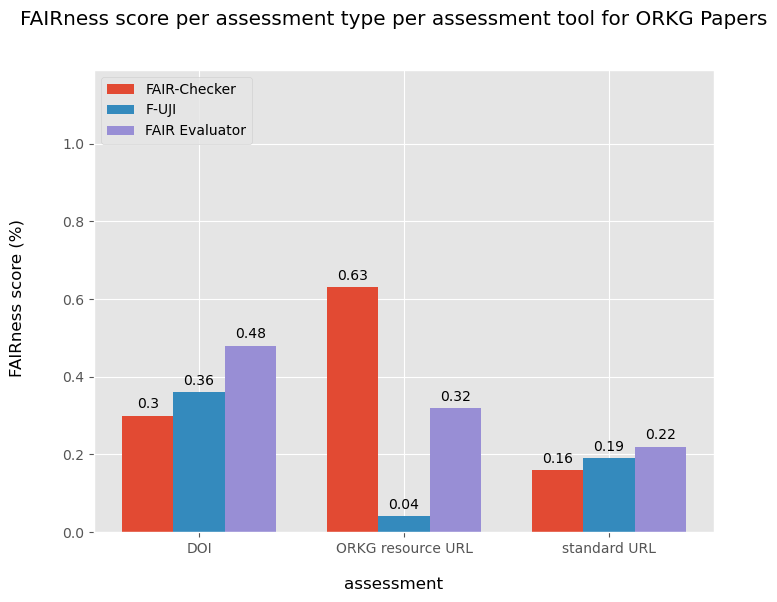

In [90]:
assessments = ("DOI", "ORKG resource URL", "standard URL")

fairscores = {
    "FAIR-Checker": (np.mean(fcheck_papers_all_df_total["score_percent_doi"]).round(decimals=2), np.mean(fcheck_papers_all_df_total["score_percent_url"]).round(decimals=2), np.mean(fcheck_papers_all_df_total["score_percent_std"]).round(decimals=2)),
    "F-UJI": (np.mean(fuji_papers_all_df_total["score_percent_doi"]).round(decimals=2), np.mean(fuji_papers_all_df_total["score_percent_url"]).round(decimals=2), np.mean(fuji_papers_all_df_total["score_percent_std"]).round(decimals=2)),
    "FAIR Evaluator": (np.mean(fes_papers_all_df_total["score_percent_doi"]).round(decimals=2), np.mean(fes_papers_all_df_total["score_percent_url"]).round(decimals=2), np.mean(fes_papers_all_df_total["score_percent_std"]).round(decimals=2))
}

x = np.arange(len(assessments))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize=(8,6))
for attribute, measurement in fairscores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, assessments)
ax.set_ylim(0, 1.19)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left")

fig.supylabel("FAIRness score (%)")
fig.supxlabel("assessment")
fig.suptitle("FAIRness score per assessment type per assessment tool for ORKG Papers", fontsize="x-large")
plt.show()

# A plot comparing the FAIRness scores of Papers for the FAIR principles across all evaluated assessment tools considering DOI and ORKG resource URL assessment

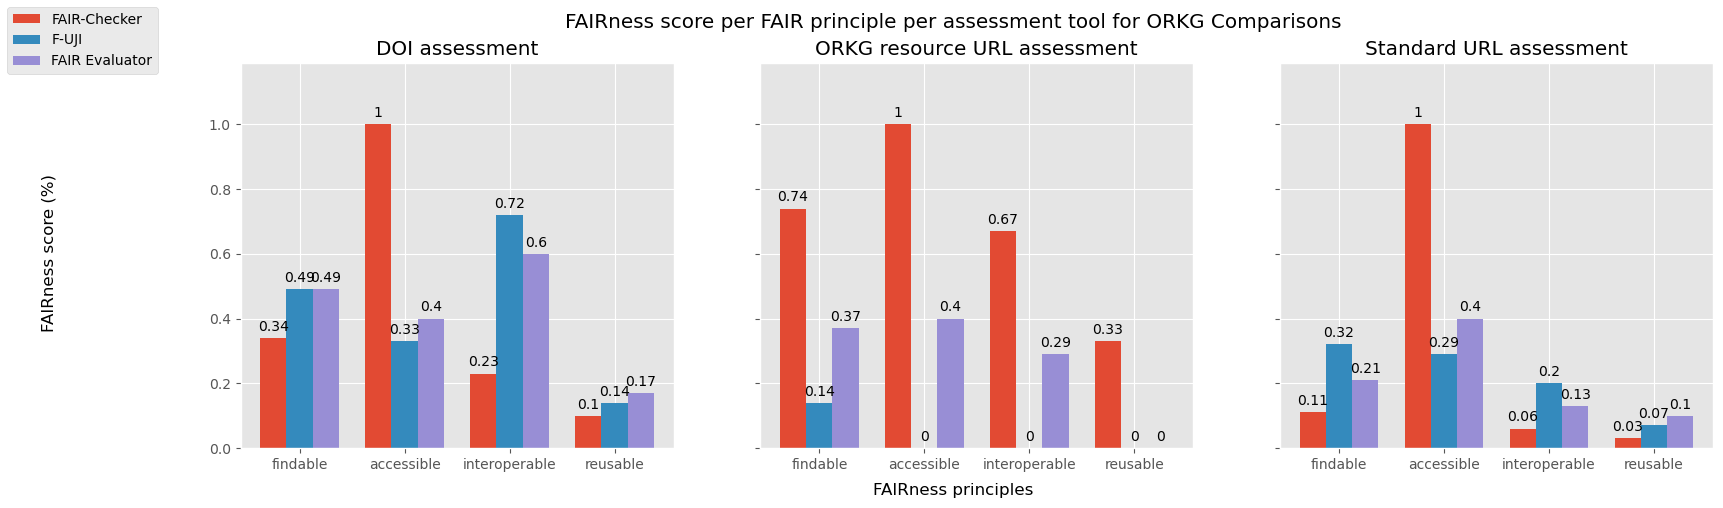

In [137]:
principles = ("findable", "accessible", "interoperable", "reusable")
fairscores_doi = {
    "FAIR-Checker": tuple(fcheck_papers_all_df_principle["score_percent_doi"].round(decimals=2)),
    "F-UJI": tuple(fuji_papers_all_df_principle["score_percent_doi"].round(decimals=2)),
    "FAIR Evaluator": tuple(fes_papers_all_df_principle["score_percent_doi"].round(decimals=2))
}
fairscores_url = {
    "FAIR-Checker": tuple(fcheck_papers_all_df_principle["score_percent_url"].round(decimals=2)),
    "F-UJI": tuple(fuji_papers_all_df_principle["score_percent_url"].round(decimals=2)),
    "FAIR Evaluator": tuple(fes_papers_all_df_principle["score_percent_url"].round(decimals=2))
}
fairscores_std = {
    "FAIR-Checker": tuple(fcheck_papers_all_df_principle["score_percent_std"].round(decimals=2)),
    "F-UJI": tuple(fuji_papers_all_df_principle["score_percent_std"].round(decimals=2)),
    "FAIR Evaluator": tuple(fes_papers_all_df_principle["score_percent_std"].round(decimals=2))
}

x = np.arange(len(principles))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(1,3, sharey=True, figsize=(19, 5))
for attribute, measurement in fairscores_doi.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute)
    ax[0].bar_label(rects, padding=3)
    multiplier += 1

multiplier = 0
for attribute, measurement in fairscores_url.items():
    offset = width * multiplier
    rects = ax[1].bar(x + offset, measurement, width, label=attribute)
    ax[1].bar_label(rects, padding=3)
    multiplier += 1

multiplier = 0
for attribute, measurement in fairscores_std.items():
    offset = width * multiplier
    rects = ax[2].bar(x + offset, measurement, width, label=attribute)
    ax[2].bar_label(rects, padding=3)
    multiplier +=1

ax[0].set_xticks(x + width, principles)
ax[0].set_ylim(0, 1.19)
ax[0].title.set_text("DOI assessment")
ax[1].set_xticks(x + width, principles)
ax[1].title.set_text("ORKG resource URL assessment")
ax[2].set_xticks(x + width, principles)
ax[2].title.set_text("Standard URL assessment")

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left")
fig.supylabel("FAIRness score (%)")
fig.supxlabel("FAIRness principles")
fig.suptitle("FAIRness score per FAIR principle per assessment tool for ORKG Comparisons", fontsize="x-large")
plt.show()

_______________________________________________________

# Comparing comparisons assessments

In [92]:
def expand_fcheck_comp_df(df):
    df_exp = pd.DataFrame()
    df_exp["comparison"] = list(chain.from_iterable([[x]*11 for x in df["comparisons"]]))
    df_exp["doi"] = list(chain.from_iterable([[x]*11 for x in df["doi"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["FAIR_assessment"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["FAIR_assessment"]]))
    df_exp["score_total"] = list(chain.from_iterable([[2]*11 for x in df["comparisons"]]))
    return df_exp

FAIR-Checker

In [93]:
fcheck_comp_doi_df = pd.read_csv("assessed_data/comparison_doi_df_FAIRChecker_assessment2023-03-29.csv", index_col=0)
fcheck_comp_url_df = pd.read_csv("assessed_data/comparison_orkg_df_FAIRChecker_assessment2023-03-29.csv", index_col=0)

In [94]:
print(fcheck_comp_doi_df["assessment_status_code"].value_counts())
print(fcheck_comp_url_df["assessment_status_code"].value_counts())
fcheck_comp_url_df = fcheck_comp_url_df[fcheck_comp_url_df["assessment_status_code"]==200].reset_index(drop=True)

200    294
Name: assessment_status_code, dtype: int64
200    975
500    173
504      1
Name: assessment_status_code, dtype: int64


In [95]:
fcheck_comp_doi_df = fcheck_comp_doi_df.drop(labels=["assessment_status_code"], axis=1)
fcheck_comp_doi_df["FAIR_assessment"] = fcheck_comp_doi_df["FAIR_assessment"].map(lambda x: build_assessment_json(x))
fcheck_comp_doi_df = expand_fcheck_comp_df(fcheck_comp_doi_df)
fcheck_comp_doi_df["score_percent"] = fcheck_comp_doi_df.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fcheck_comp_url_df = fcheck_comp_url_df.drop(labels=["assessment_status_code"], axis=1)
fcheck_comp_url_df["FAIR_assessment"] = fcheck_comp_url_df["FAIR_assessment"].map(lambda x: build_assessment_json(x))
fcheck_comp_url_df = expand_fcheck_comp_df(fcheck_comp_url_df)
fcheck_comp_url_df["score_percent"] = fcheck_comp_url_df.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)

In [96]:
fcheck_comp_doi_df_total = fcheck_comp_doi_df
fcheck_comp_doi_df_total = fcheck_comp_doi_df_total.groupby("comparison").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
fcheck_comp_doi_df_total["score_percent"] = fcheck_comp_doi_df_total.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fcheck_comp_url_df_total = fcheck_comp_url_df
fcheck_comp_url_df_total = fcheck_comp_url_df_total.groupby("comparison").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
fcheck_comp_url_df_total["score_percent"] = fcheck_comp_url_df_total.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)


In [97]:
fcheck_comp_doi_df_principle = fcheck_comp_doi_df
fcheck_comp_doi_df_principle["principle"] = fcheck_comp_doi_df_principle["metric"].map(lambda x: get_principle_from_metric_fairchecker(x))
fcheck_comp_doi_df_principle = fcheck_comp_doi_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fcheck_comp_doi_df_principle["score_percent"] = fcheck_comp_doi_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fcheck_comp_doi_df_principle['principle'] = pd.Categorical(fcheck_comp_doi_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fcheck_comp_doi_df_principle = fcheck_comp_doi_df_principle.sort_values('principle')
fcheck_comp_url_df_principle = fcheck_comp_url_df
fcheck_comp_url_df_principle["principle"] = fcheck_comp_url_df_principle["metric"].map(lambda x: get_principle_from_metric_fairchecker(x))
fcheck_comp_url_df_principle = fcheck_comp_url_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fcheck_comp_url_df_principle["score_percent"] = fcheck_comp_url_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fcheck_comp_url_df_principle['principle'] = pd.Categorical(fcheck_comp_url_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fcheck_comp_url_df_principle = fcheck_comp_url_df_principle.sort_values('principle')

____________________________________________________

F-UJI

In [98]:
fuji_comp_doi_df = pd.read_csv("assessed_data/comparison_doi_df_F-UJI_assessment.csv", index_col=0)
fuji_comp_url_df = pd.read_csv("assessed_data/comparison_url_df_F-UJI_assessment.csv", index_col=0)

In [99]:
fuji_comp_doi_df_total = fuji_comp_doi_df
fuji_comp_doi_df_total = fuji_comp_doi_df_total.groupby("comparison").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
fuji_comp_doi_df_total["score_percent"] = fuji_comp_doi_df_total.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fuji_comp_url_df_total = fuji_comp_url_df
fuji_comp_url_df_total = fuji_comp_url_df_total.groupby("comparison").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
fuji_comp_url_df_total["score_percent"] = fuji_comp_url_df_total.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)

In [100]:
fuji_comp_doi_df_principle = fuji_comp_doi_df
fuji_comp_doi_df_principle["principle"] = fuji_comp_doi_df_principle["metric"].map(lambda x: get_principle_from_metric_fuji(x))
fuji_comp_doi_df_principle = fuji_comp_doi_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fuji_comp_doi_df_principle["score_percent"] = fuji_comp_doi_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fuji_comp_doi_df_principle['principle'] = pd.Categorical(fuji_comp_doi_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fuji_comp_doi_df_principle = fuji_comp_doi_df_principle.sort_values('principle')
fuji_comp_url_df_principle = fuji_comp_url_df
fuji_comp_url_df_principle["principle"] = fuji_comp_url_df_principle["metric"].map(lambda x: get_principle_from_metric_fuji(x))
fuji_comp_url_df_principle = fuji_comp_url_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fuji_comp_url_df_principle["score_percent"] = fuji_comp_url_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fuji_comp_url_df_principle['principle'] = pd.Categorical(fuji_comp_url_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
fuji_comp_url_df_principle = fuji_comp_url_df_principle.sort_values('principle')

_______________________________________________________

In [101]:
def expand_fes_comp_df(df):
    df_exp = pd.DataFrame()
    df_exp["comparison"] = list(chain.from_iterable([[x]*22 for x in df["comparisons"]]))
    df_exp["doi"] = list(chain.from_iterable([[x]*22 for x in df["doi"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score_total"] = list(chain.from_iterable([[1]*22 for x in df["comparisons"]]))
    return df_exp

FAIR Evaluation Services

In [102]:
fes_comp_doi_df = pd.read_csv("assessed_data/comparison_doi_df_FES_assessment.csv", index_col=0)
fes_comp_url_df = pd.read_csv("assessed_data/comparison_url_df_FES_assessment.csv", index_col=0)

In [103]:
fes_comp_doi_df["assessment_result"] = fes_comp_doi_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
fes_comp_doi_df["assessment_result"] = fes_comp_doi_df["assessment_result"].map(lambda x: json.loads(x))
fes_comp_doi_df = expand_fes_comp_df(fes_comp_doi_df)
fes_comp_doi_df["metric"] = fes_comp_doi_df["metric"].map(lambda x: adjust_fes_metric_names(x))
fes_comp_url_df["assessment_result"] = fes_comp_url_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
fes_comp_url_df["assessment_result"] = fes_comp_url_df["assessment_result"].map(lambda x: json.loads(x))
fes_comp_url_df = expand_fes_comp_df(fes_comp_url_df)
fes_comp_url_df["metric"] = fes_comp_url_df["metric"].map(lambda x: adjust_fes_metric_names(x))

In [104]:
fes_comp_doi_df_total = fes_comp_doi_df
fes_comp_doi_df_total = fes_comp_doi_df_total.groupby("comparison").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
fes_comp_doi_df_total["score_percent"] = fes_comp_doi_df_total.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fes_comp_url_df_total = fes_comp_url_df
fes_comp_url_df_total = fes_comp_url_df_total.groupby("comparison").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
fes_comp_url_df_total["score_percent"] = fes_comp_url_df_total.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)

In [105]:
fes_comp_doi_df_principle = fes_comp_doi_df
fes_comp_doi_df_principle["principle"] = fes_comp_doi_df_principle["metric"].map(lambda x: get_principle_from_metric_fairchecker(x))
fes_comp_doi_df_principle = fes_comp_doi_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fes_comp_doi_df_principle["score_percent"] = fes_comp_doi_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fes_comp_doi_df_principle["principle"] = pd.Categorical(fes_comp_doi_df_principle["principle"], ["findable", "accessible", "interoperable", "reusable"])
fes_comp_doi_df_principle = fes_comp_doi_df_principle.sort_values("principle")
fes_comp_url_df_principle = fes_comp_url_df
fes_comp_url_df_principle["principle"] = fes_comp_url_df_principle["metric"].map(lambda x: get_principle_from_metric_fairchecker(x))
fes_comp_url_df_principle = fes_comp_url_df_principle.groupby("principle").agg({"score_earned": "mean", "score_total": "mean"}).reset_index()
fes_comp_url_df_principle["score_percent"] = fes_comp_url_df_principle.apply(lambda x: x["score_earned"]/x["score_total"], axis=1)
fes_comp_url_df_principle["principle"] = pd.Categorical(fes_comp_url_df_principle["principle"], ["findable", "accessible", "interoperable", "reusable"])
fes_comp_url_df_principle = fes_comp_url_df_principle.sort_values("principle")

________________________________________________________

# A plot comparing the total FAIRness score for Comparisons across all evaluated assessment tools considering DOI and ORKG resource URL assessment

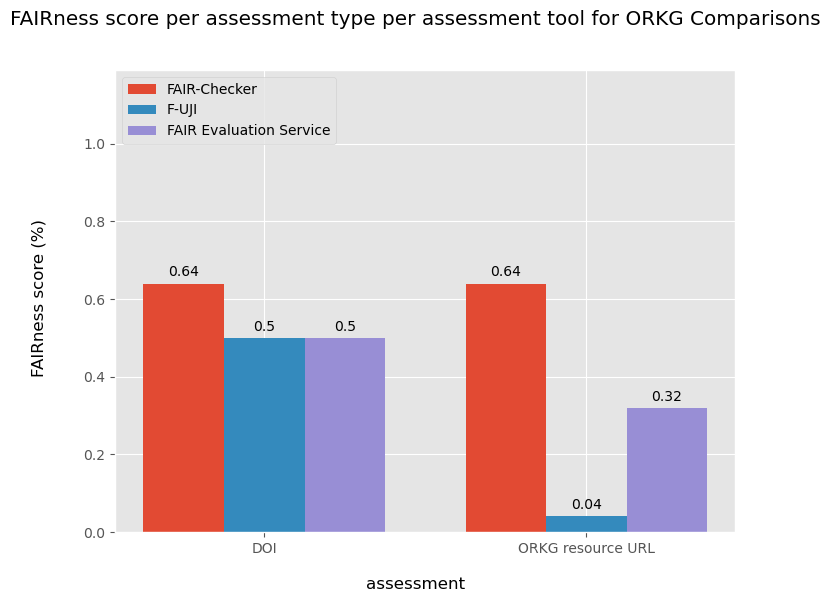

In [106]:
assessments = ("DOI", "ORKG resource URL")

fcheck_fuji_comp_doi_df_total = pd.merge(fcheck_comp_doi_df_total, fuji_comp_doi_df_total, on="comparison", suffixes=("_fcheck", "_fuji"))
all_comp_doi_df_total = pd.merge(fcheck_fuji_comp_doi_df_total, fes_comp_doi_df_total, on="comparison")
all_comp_doi_df_total.rename(columns={"score_earned": "score_earned_fes", "score_total": "score_total_fes", "score_percent": "score_percent_fes"}, inplace=True)

fcheck_fuji_comp_url_df_total = pd.merge(fcheck_comp_url_df_total, fuji_comp_url_df_total, on="comparison", suffixes=("_fcheck", "_fuji"))
all_comp_url_df_total = pd.merge(fcheck_fuji_comp_url_df_total, fes_comp_url_df_total, on="comparison")
all_comp_url_df_total.rename(columns={"score_earned": "score_earned_fes", "score_total": "score_total_fes", "score_percent": "score_percent_fes"}, inplace=True)

fairscores = {
    "FAIR-Checker": (np.mean(all_comp_doi_df_total["score_percent_fcheck"]).round(decimals=2), np.mean(all_comp_url_df_total["score_percent_fcheck"]).round(decimals=2)),
    "F-UJI": (np.mean(all_comp_doi_df_total["score_percent_fuji"]).round(decimals=2), np.mean(all_comp_url_df_total["score_percent_fuji"]).round(decimals=2)),
    "FAIR Evaluation Service": (np.mean(all_comp_doi_df_total["score_percent_fes"]).round(decimals=2), np.mean(all_comp_url_df_total["score_percent_fes"]).round(decimals=2))
}

x = np.arange(len(assessments))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize=(8,6))
for attribute, measurement in fairscores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xticks(x + width, assessments)
ax.set_ylim(0, 1.19)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left")

fig.supylabel("FAIRness score (%)")
fig.supxlabel("assessment")
fig.suptitle("FAIRness score per assessment type per assessment tool for ORKG Comparisons", fontsize="x-large")
plt.show()

# A plot comparing the FAIRness scores of Comparisons for the FAIR principles across all evaluated assessment tools considering DOI and ORKG resource URL assessment

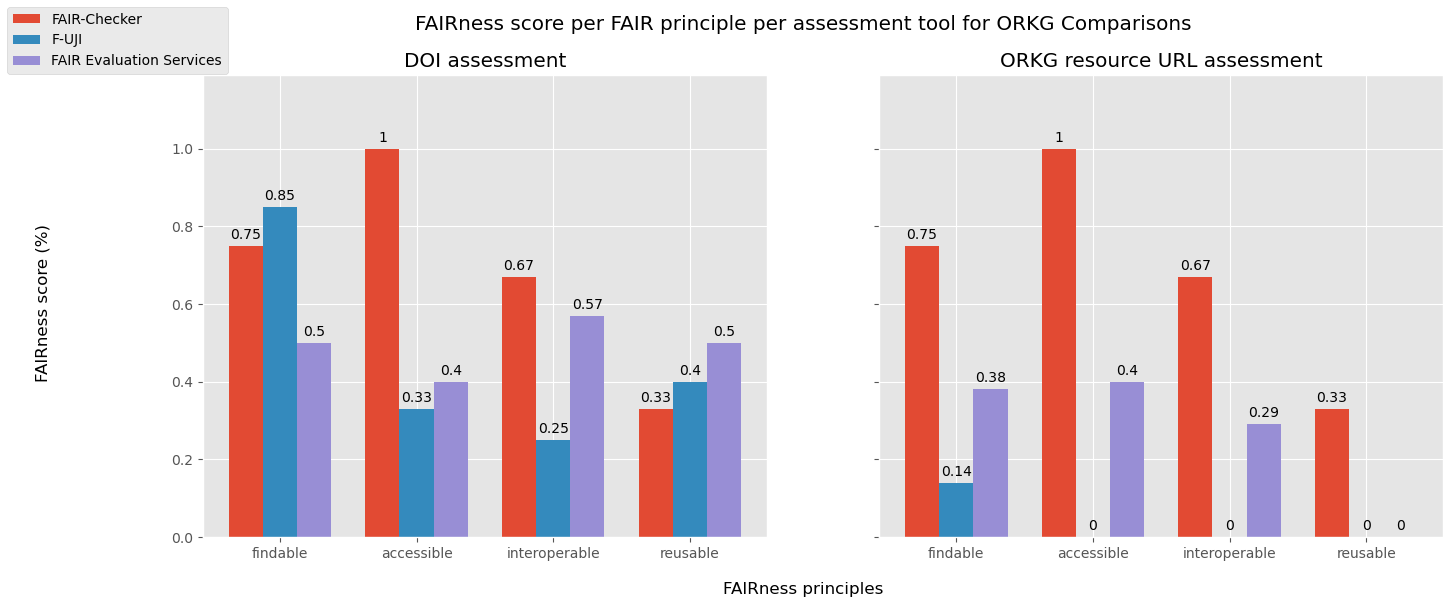

In [107]:
principles = ("findable", "accessible", "interoperable", "reusable")
fairscores_doi = {
    "FAIR-Checker": tuple(fcheck_comp_doi_df_principle["score_percent"].round(decimals=2)),
    "F-UJI": tuple(fuji_comp_doi_df_principle["score_percent"].round(decimals=2)),
    "FAIR Evaluation Services": tuple(fes_comp_doi_df_principle["score_percent"].round(decimals=2))
}
fairscores_url = {
    "FAIR-Checker": tuple(fcheck_comp_url_df_principle["score_percent"].round(decimals=2)),
    "F-UJI": tuple(fuji_comp_url_df_principle["score_percent"].round(decimals=2)),
    "FAIR Evaluation Services": tuple(fes_comp_url_df_principle["score_percent"].round(decimals=2))
}

x = np.arange(len(principles))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(1,2, sharey=True, figsize=(16, 6))
for attribute, measurement in fairscores_doi.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute)
    ax[0].bar_label(rects, padding=3)
    multiplier += 1

multiplier = 0
for attribute, measurement in fairscores_url.items():
    offset = width * multiplier
    rects = ax[1].bar(x + offset, measurement, width, label=attribute)
    ax[1].bar_label(rects, padding=3)
    multiplier += 1

ax[0].set_xticks(x + width, principles)
ax[0].set_ylim(0, 1.19)
ax[0].title.set_text("DOI assessment")
ax[1].set_xticks(x + width, principles)
ax[1].title.set_text("ORKG resource URL assessment")

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left")
fig.supylabel("FAIRness score (%)")
fig.supxlabel("FAIRness principles")
fig.suptitle("FAIRness score per FAIR principle per assessment tool for ORKG Comparisons", fontsize="x-large")
plt.show()